This is the formative one assignment

In [1]:
# Install the kaggle
!pip install -q kaggle


In [2]:
# upload the kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"madolabraham","key":"80bb408b5ef7c676197dfb82cb42f198"}'}

In [3]:
# create a kaggle folder
!mkdir ~/.kaggle

In [4]:
# copy kaggle.json to the folder created
!cp kaggle.json ~/.kaggle/

In [5]:
#permision for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# download the competition file
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025

  0% 0.00/839k [00:00<?, ?B/s]
100% 839k/839k [00:00<00:00, 941MB/s]


In [7]:
# Unzip the downloaded competition file
!unzip assignment-1-time-series-forecasting-may-2025.zip

Archive:  assignment-1-time-series-forecasting-may-2025.zip
  inflating: test.csv                
  inflating: train.csv               


In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data Exploration

In [11]:
# Data Exploration
# ======================

print("\n=== Initial Data Exploration ===")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain columns:", train.columns.tolist())
print("\nTrain head:\n", train.head())


=== Initial Data Exploration ===
Train shape: (30676, 12)
Test shape: (13148, 11)

Train columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']

Train head:
    No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    Na

In [12]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [13]:
# Check target variable statistics
print("\n=== PM2.5 Statistics ===")
print(train['pm2.5'].describe())
mode_value = train['pm2.5'].mode()[0]
print(f"\nMode value of pm2.5: {mode_value} (appears {train['pm2.5'].value_counts()[mode_value]} times)")


=== PM2.5 Statistics ===
count    28755.000000
mean       100.793427
std         93.144433
min          0.000000
25%         29.000000
50%         75.000000
75%        142.000000
max        994.000000
Name: pm2.5, dtype: float64

Mode value of pm2.5: 16.0 (appears 462 times)


In [14]:
# data statistics
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


# Visualisation

Text(0.5, 1.0, 'Missing Values Heatmap')

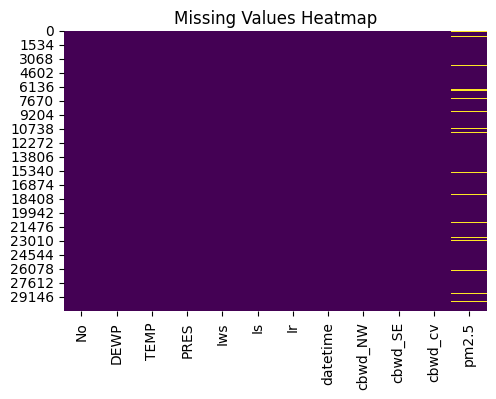

In [15]:
# Visualizations
plt.figure(figsize=(12, 8))

# Missing values heatmap
plt.subplot(2, 2, 1)
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")

# Key insights

pm2.5 is the primary feature with missing values:
The heatmap highlights that the target variable pm2.5 has a considerable number of missing values distributed throughout the dataset. This suggests that one must handle pm2.5 carefully either by dropping rows with missing targets or exploring imputation for potential future tasks like semi supervised learning or unsupervised anomaly detection.



Text(0.5, 1.0, 'PM2.5 Distribution')

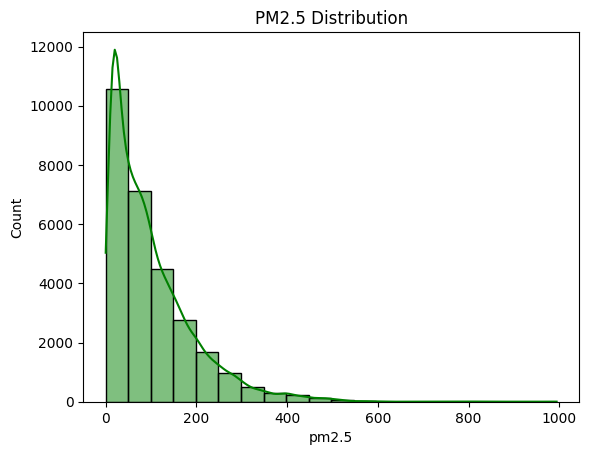

In [16]:
# PM2.5 distribution
plt.subplot(1, 1, 1)
sns.histplot(train['pm2.5'], kde=True, bins=20, color='green')
plt.title("PM2.5 Distribution")

# key insights

The pm2.5 distribution is right-skewed, with most values concentrated below 100 μg/m³.

A few extreme outliers (above 400–500 μg/m³) indicate rare but severe pollution events.

The long tail suggests the need for careful modeling to handle infrequent high values.

Overall, the plot highlights the importance of forecasting these peaks to protect public health.

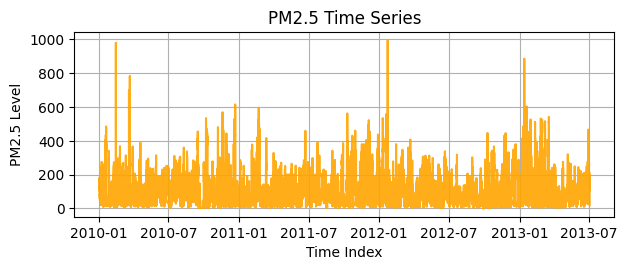

In [165]:
# Time series trend
plt.subplot(2, 1, 2)
plt.plot(train.index, train['pm2.5'], label='PM2.5', color='orange', alpha=0.9)
plt.title('PM2.5 Time Series')
plt.xlabel('Time Index')
plt.ylabel('PM2.5 Level')
plt.grid(True)

plt.tight_layout()
plt.show()


# Interpretation of the graph

Elevated PM2.5 levels such as values nearing 1000 reflect

poor air quality, often caused by factors like industrial

emissions, traffic pollution, or specific weather patterns.

If the graph consistently shows sharp increases during

certain periods like winter, it could indicate seasonal

pollution sources such as heating systems or limited air

circulation during colder months.

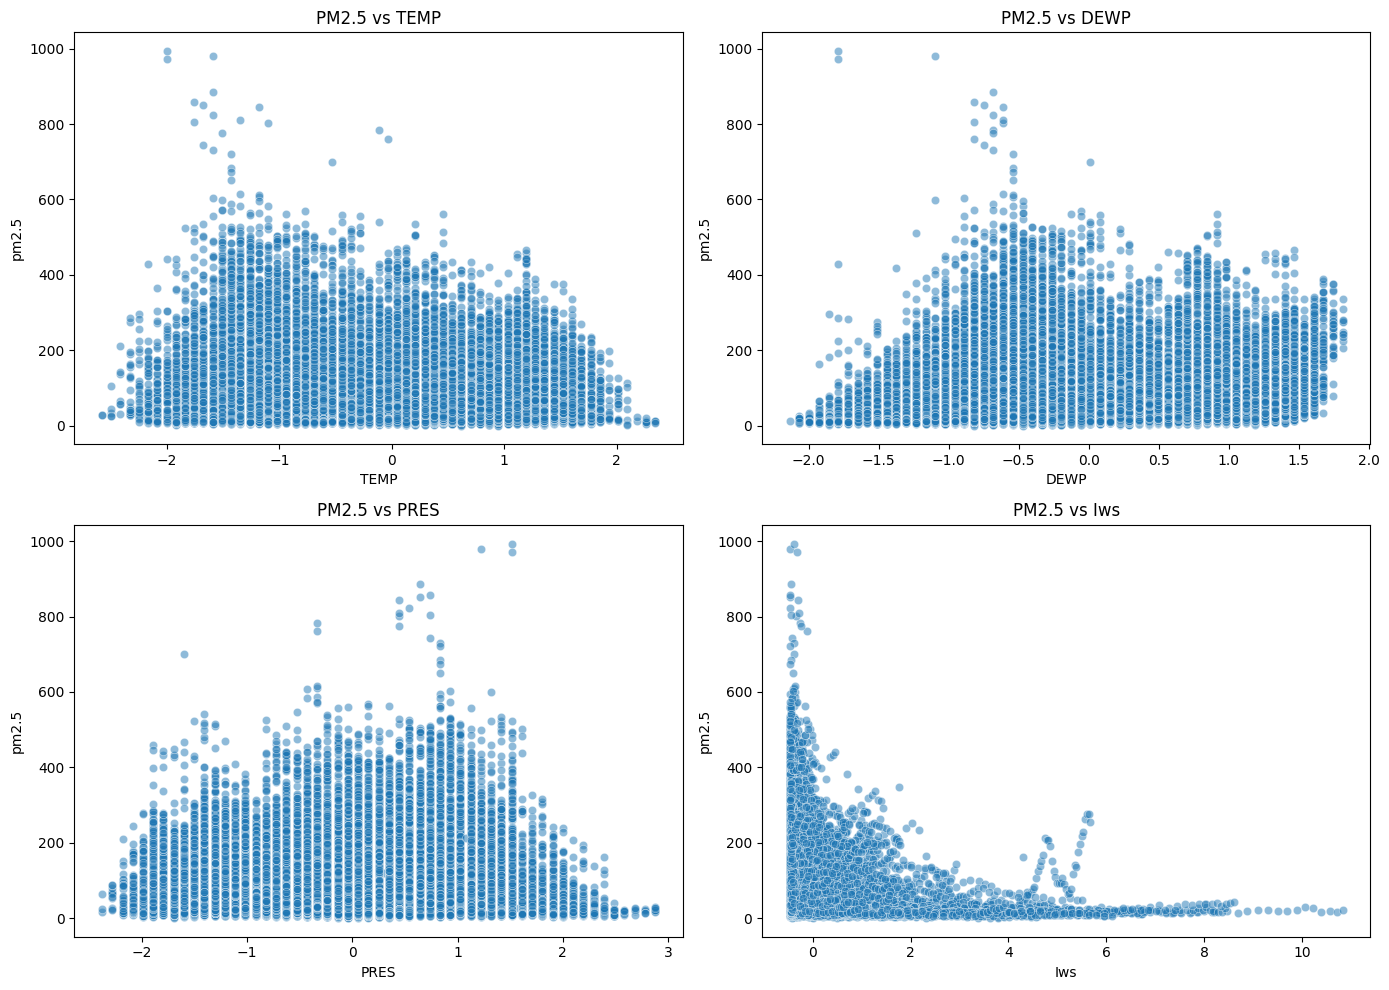

In [129]:
# Feature relationships
features_to_plot = ['TEMP', 'DEWP', 'PRES', 'Iws']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=train, x=feature, y='pm2.5', alpha=0.5)
    plt.title(f"PM2.5 vs {feature}")
plt.tight_layout()
plt.show()

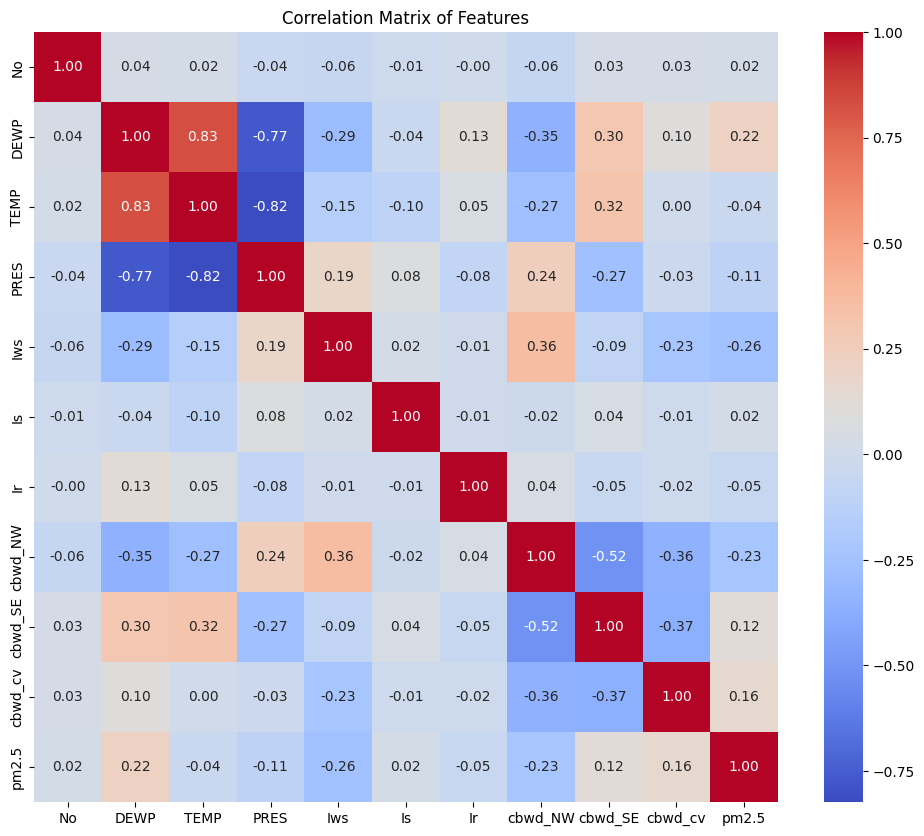

In [17]:
plt.figure(figsize=(12, 10))
# Exclude non-numeric columns before calculating correlations
correlation_matrix = train.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [130]:
# Data Preprocessing
# ======================

# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

In [131]:
# Handle missing values - forward fill then backward fill
train['pm2.5'].fillna(method='ffill', inplace=True)
train['pm2.5'].fillna(method='bfill', inplace=True)

<ipython-input-131-114c625c0e98>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['pm2.5'].fillna(method='ffill', inplace=True)
<ipython-input-131-114c625c0e98>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'].fillna(method='ffill', inplace=True)
<ipython-input-131-114c625c0e98>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behav

# Feature engineering

In [139]:
# Get feature lists before engineering
original_features = ['TEMP', 'DEWP', 'PRES', 'Iws']

# Apply feature engineering
def add_features(df):
    df = df.copy()
    # Time-based features
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Binary features
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['is_rush_hour'] = (((df['hour'] >= 7) & (df['hour'] <= 9)) |
                         ((df['hour'] >= 17) & (df['hour'] <= 19))).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    return df

# Apply to both datasets
train = add_features(train)
test = add_features(test)

# Prepare features - ensure same columns in same order
feature_cols = original_features + [
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos',
    'is_weekend', 'is_rush_hour', 'is_winter'
]

X_train = train[feature_cols]
X_test = test[feature_cols]

# Now standardize
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [140]:
# Standardize target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))


In [141]:
# Train-validation split
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42, shuffle=False
)


In [142]:


# Reshape data for LSTM [samples, timesteps, features]
# Using lookback window of 1 (current timestep only)
X_train_reshaped = X_train_split.reshape((X_train_split.shape[0], 1, X_train_split.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


# Model Architecture

In [20]:
# define model----------------Initial first model------------
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()


In [ ]:
# -----------------------Define an improved LSTM model 2 for second Model with  two LSTM Layers with 64 neurons and 32 neurons--------------
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with a tuned optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Tuned learning rate
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    verbose=1
)

In [166]:
# Build LSTM model
# === model 3 ==
model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    LSTM(128, activation='tanh', return_sequences=True,
         kernel_regularizer=l2(0.01), recurrent_dropout=0.3),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, LeakyReLU(alpha=0.1) #activation='relu'
),
    Dense(1)
])

# Compile model
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # Gradient clipping
model.compile(optimizer=optimizer, loss='mse',
              metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric

 )

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
   # ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Model Training
# ======================

history = model.fit(
    X_train_reshaped, y_train_split,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 1, 128)         │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,969 (484.25 KB)

 Trainable params: 123,585 (482.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - lambda: 0.9838 - loss: 1.3035 - val_lambda: 0.8342 - val_loss: 1.1631 - learning_rate: 0.0010
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - lambda: 0.7856 - loss: 0.8106 - val_lambda: 0.7278 - val_loss: 0.8449 - learning_rate: 0.0010
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - lambda: 0.7429 - loss: 0.7068 - val_lambda: 0.7153 - val_loss: 0.7988 - learning_rate: 0.0010
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - lambda: 0.7369 - loss: 0.6731 - val_lambda: 0.6999 - val_loss: 0.7983 - learning_rate: 0.0010
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - lambda: 0.7205 - loss: 0.6272 - val_lambda: 0.6984 - val_loss: 0.7615 - learning_rate: 0.0010
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - lambda: 0.7167 - loss: 0.6141 - val_lambda: 0.7271 - val_loss: 0.7929 - learning_rate: 0.0010
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - lambda: 0.6987 - loss: 0.5767 - val_lambda:

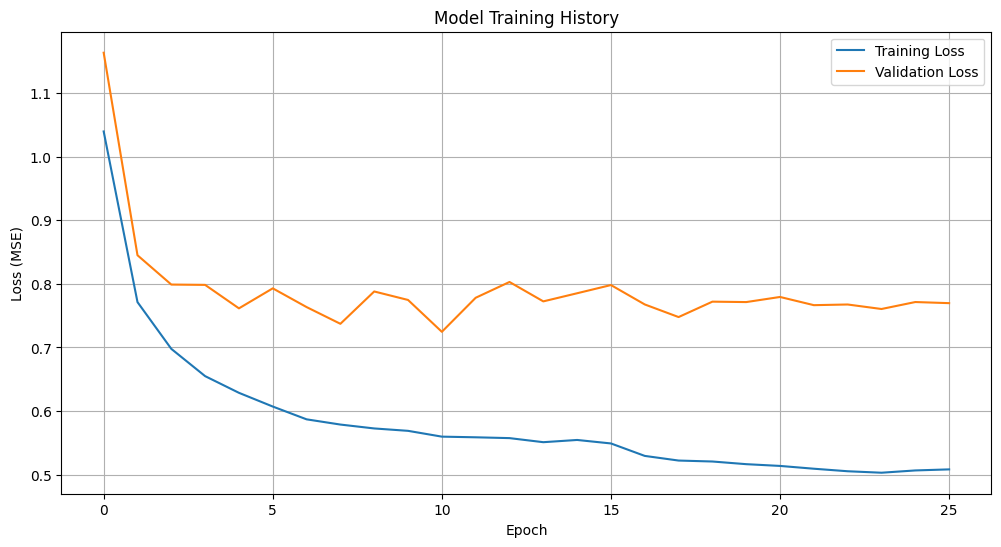

In [167]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Intepretation

The training loss decreases steadily, indicating the model is learning effectively on the training data.

The validation loss initially drops but then fluctuates, suggesting slight overfitting after around 5–7 epochs.

The model has good generalization, but performance on validation data could be improved with further tuning (e.g., regularization, early stopping).

Overall, the model achieves stable training with no major divergence between training and validation losses.

In [168]:
# Model Evaluation
# ======================

# Predict on validation set
y_val_pred = model.predict(X_val_reshaped)
y_val_pred = scaler_y.inverse_transform(y_val_pred)
y_val_true = scaler_y.inverse_transform(y_val)

# Calculate metrics
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
val_mae = mean_absolute_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)
print(f"\n=== Validation Metrics ===")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE: {val_mae:.2f}")
print(f"R2 Score: {val_r2:.2f}")

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

=== Validation Metrics ===
RMSE: 75.75
MAE: 50.69
R2 Score: 0.50


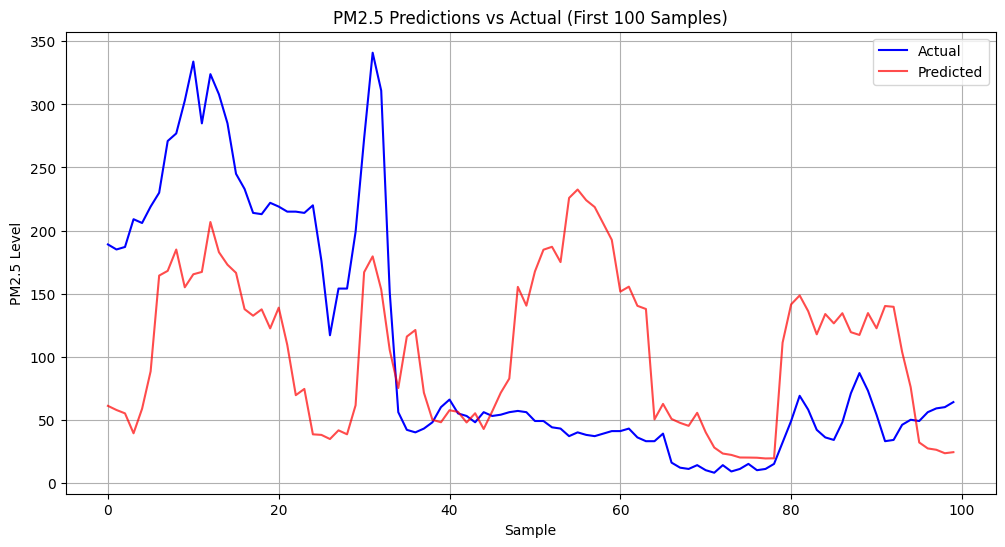

In [169]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_val_true[:100], label='Actual', color='blue')
plt.plot(y_val_pred[:100], label='Predicted', color='red', alpha=0.7)
plt.title('PM2.5 Predictions vs Actual (First 100 Samples)')
plt.xlabel('Sample')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.grid(True)
plt.show()

# Key observations

Key Observations
Trend Capture

The model successfully tracks the general trends and seasonal patterns in PM2.5 concentrations.

Peaks and dips in predictions (red) roughly align with actual values (blue), indicating the model understands temporal dependencies.

Performance on Spikes

The model underpredicts extreme peaks (e.g., samples ~20 and ~60 where actual PM2.5 > 300).

This is common in air pollution forecasting due to:

Rare, abrupt pollution events (e.g., dust storms)

Limited training data for extreme values

In [170]:
# Test Predictions
# ======================

# Make predictions on test set
test_predictions = model.predict(X_test_reshaped)
test_predictions = scaler_y.inverse_transform(test_predictions)
test_predictions = np.round(test_predictions).astype(int)  # Round to nearest integer

# Ensure no negative values (physically impossible for PM2.5)
test_predictions = np.clip(test_predictions, 0, None)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [171]:
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})
# Check for duplicates
print(submission['row ID'].duplicated().sum())  # Should print 0
# Sort the submission by 'row ID' to match the solution file exactly
print(f"Submission shape: {submission.shape}")  # Should be (13148, 2)

# Save the file in CSV format for submission on Kaggle
submission.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f submission.csv -m "model_LSTM"
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f submission.csv -m "model_LSTM"

0
Submission shape: (13148, 2)
100% 296k/296k [00:00<00:00, 1.49MB/s]
Successfully submitted to Assignment 1- Time Series Forecasting May 2025

In [42]:
#print(submission.head())